In [1]:
import torch
import sys

sys.path.append('..')

from SourceCode import *
from math import pi

In [2]:
#%matplotlib notebook
#from ipywidgets import *

# №1

$$ U_{xx}+U_{yy}+1=0 $$
$$U(-1,y)=0$$
$$U(1,y)=0$$
$$U(x,-1)=0$$
$$U(x,1)=0$$
$$ Analytical\_sol = (\frac{8}{\pi^2})^2\sum_{i=1,3,5..}\sum_{j=1,3,5..}\frac{(-1)^{(i+j)/2-1}}{i*j*(i^2+j^2)}cos(i\frac{\pi}{2}x)cos(j\frac{\pi}{2}y)$$
$$ approximation\_satisfying\_init\_conditions: appr = (1-x^2)(1-y^2)nn\_model(x,y) $$
$$ x \in [-1, 1] $$
$$ y \in [-1, 1] $$

here is an example how we can explicitly specify approximation satifying boundary conditions so we dont have to pass boundary conditions as arguments

In [3]:
def true_solution(x, y):
    total_sum = 0
    lim = 100
    for i in range(1, lim, 2):
        for j in range(1, lim, 2):
            total_sum += pow(-1, (i + j) // 2 - 1) / (i * j * (i * i + j * j)) * torch.cos(
                i * pi / 2 * x) * torch.cos(j * pi / 2 * y)
    total_sum *= 8*8/(pi*pi*pi*pi)
    return total_sum

In [4]:
x1_points = 20
x1_left = -1
x1_right = 1
x2_points = 20
x2_left = -1
x2_right = 1
    
    

    
main_domain = TwoDimensionalSimpleDomain(x1_points,
                                            x1_left,
                                            x1_right,
                                            x2_points,
                                            x2_left,
                                            x2_right)
main_eq_residuals = lambda x, y, nn_model: (nth_derivative(nn_model(x, y), x, 2) +
                                            nth_derivative(nn_model(x, y), y, 2) +
                                            torch.tensor(1.0, requires_grad=True))
    
main_eq = MainEquationClass(main_domain, main_eq_residuals)
boundary_satisfying_models = [
    lambda x, y, model: model(x, y) * (1 - x * x) * (1 - y * y)
]
    
n_epochs = 50
models = NNGenerator.generate_models(
            nn_count=1, inp_dim=2, boundary_satisfying_models=boundary_satisfying_models
        )

nn_ode_solver = TrainerForNNEquationSolver(
            main_eq, n_epochs=n_epochs, nn_models=models,
    lr=0.5
)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()

In [6]:
report = ReportMaker(nn_models,
                        main_domain,
                        compare_to_functions=plot_two_2d_functions,
                        analytical_solutions=true_solution,
                        main_eq_residuals=main_eq_residuals
)

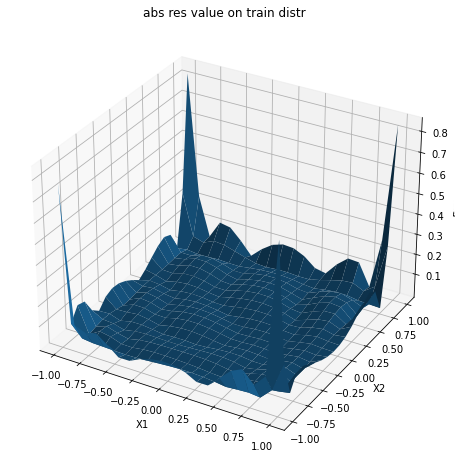

In [7]:
report.plot_abs_residual_distr()

Max residual value |R[NN]| on train: 0.8475139737129211
Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.001513838768005371
Valid max absolute error |Appr(x)-y(x)|: 0.0014590844511985779
MAPE on train data: 0.267435098066926 %
MAPE on validation data: 0.2659979974851012 %


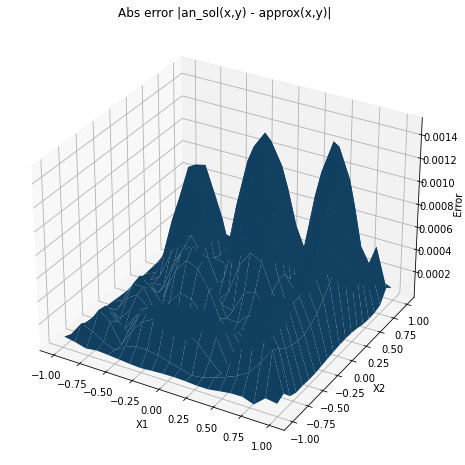

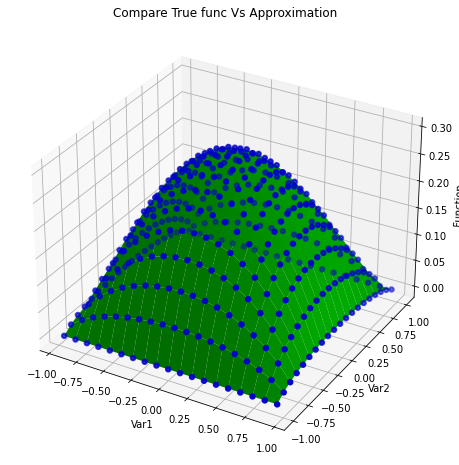

In [9]:
report.compare_appr_with_analytical()

# № 2

$$ U_{xx}+U_{yy}+1=0 $$
$$U(-1,y)=0$$
$$U(1,y)=0$$
$$U(x,-1)=0$$
$$U(x,1)=0$$
$$ Analytical\_sol = (\frac{8}{\pi^2})^2\sum_{i=1,3,5..}\sum_{j=1,3,5..}\frac{(-1)^{(i+j)/2-1}}{i*j*(i^2+j^2)}cos(i\frac{\pi}{2}x)cos(j\frac{\pi}{2}y)$$
$$ x \in [-1, 1] $$
$$ y \in [-1, 1] $$

here an example of specifying init conditions if approximation satisfying them is unknown

In [10]:
x1_points = 20
x1_left = -1
x1_right = 1
x2_points = 20
x2_left = -1
x2_right = 1
    

    
main_domain = TwoDimensionalSimpleDomain(x1_points,
                                            x1_left,
                                            x1_right,
                                            x2_points,
                                            x2_left,
                                            x2_right,
                                        offset=0.01)
main_eq_residuals = lambda x, y, nn_model: (nth_derivative(nn_model(x, y), x, 2) +
                                            nth_derivative(nn_model(x, y), y, 2) +
                                            torch.tensor(1.0, requires_grad=True))
    
bc = lambda x, y, model: model(x,y)
bc1 = TwoDimInitialCondition(non_const_var_left_value=-1,
                                            non_const_var_right_value=1,
                                            non_const_var_size=10,
                                            equation=bc,
                                            const_var_value=1,
                                            const_var_ind=1)

bc2 = TwoDimInitialCondition(-1, 1, 10, bc, -1, 1)
bc3 = TwoDimInitialCondition(-1, 1, 10, bc, 1, 2)
bc4 = TwoDimInitialCondition(-1, 1, 10, bc, -1, 2)
boundary_conditions = [bc1, bc2, bc3, bc4]
main_eq = MainEquationClass(main_domain,
                                main_eq_residuals,
                                boundary_conditions=boundary_conditions,
                           bound_cond_coef=0.1)
    
n_epochs = 50
nn_params = {'hidden_dim': 50, 'num_hidden_layers': 1}
models = NNGenerator.generate_models(nn_count=1, inp_dim=2,
                                             nn_params=nn_params)

nn_ode_solver = TrainerForNNEquationSolver(
            main_eq, n_epochs=n_epochs, nn_models=models,
            lr=0.5
)
loss_train, loss_valid, abs_err_train, abs_err_valid, nn_models = nn_ode_solver.fit_with_abs_err_history(main_domain ,
                                                                                                         [true_solution])

In [11]:
report = ReportMaker(nn_models,
                        main_domain,
                        compare_to_functions=plot_two_2d_functions,
                        analytical_solutions=true_solution,
                        main_eq_residuals=main_eq_residuals
                        )

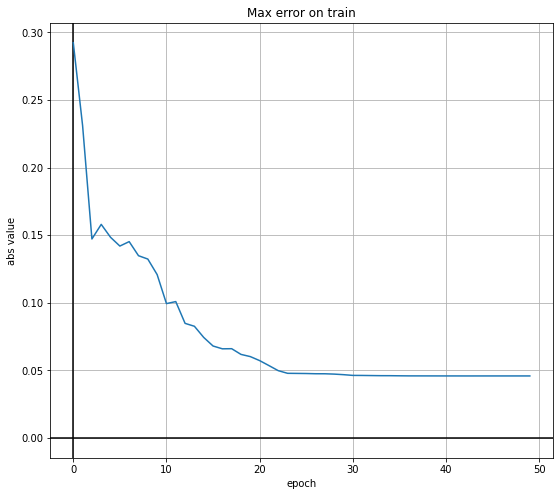

Value at last epoch: 0.045909278094768524


In [12]:
report.plot_error_history(abs_err_train)

Max residual value |R[NN]| on train: 0.043799757957458496
Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.045909278094768524
Valid max absolute error |Appr(x)-y(x)|: 0.04093360900878906
MAPE on train data: 11.50026023387909 %
MAPE on validation data: 10.977756977081299 %


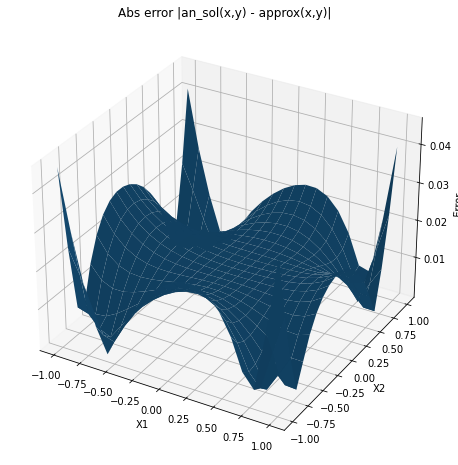

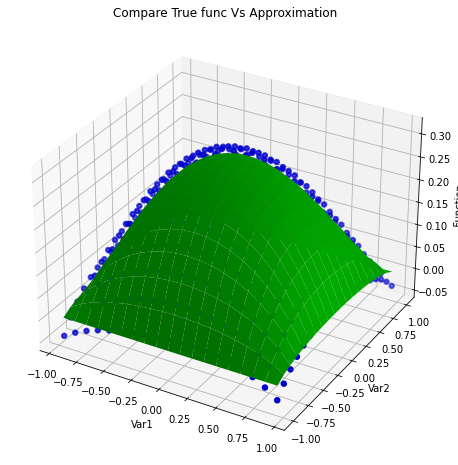

In [14]:
report.compare_appr_with_analytical()

# № 3

$$ u_{xx} + u_{yy} = 0$$
$$ u(x,0)=u(0,y)=u(2,y)=0 $$
$$ u(x,2)=sin(x\frac{\pi}{2}) $$
$$ true\_sol = \frac{1}{sinh(\pi)}sinh(\pi*y/2)sin(\pi*x/2) $$

In [15]:
x1_points = 20
x1_left = 0
x1_right = 2
x2_points = 20
x2_left = 0
x2_right = 2
    

offset = 0.01
main_domain = TwoDimensionalSimpleDomain(x1_points,
                                            x1_left,
                                            x1_right,
                                            x2_points,
                                            x2_left,
                                            x2_right)
main_eq_residuals = lambda x, y, nn_model: (nth_derivative(nn_model(x, y), x, 2) +
                                            nth_derivative(nn_model(x, y), y, 2))
    
bc = lambda x, y, model: model(x,y)
bc_non_const = lambda x, y, model: model(x,y)-torch.sin(x*torch.pi/2)
bc1 = TwoDimInitialCondition(non_const_var_left_value=0,
                                            non_const_var_right_value=2,
                                            non_const_var_size=10,
                                            equation=bc,
                                            const_var_value=0,
                                            const_var_ind=1)

bc2 = TwoDimInitialCondition(0, 2, 10, bc, 2, 1)
bc3 = TwoDimInitialCondition(0 + offset, 2 - offset, 10, bc, 0, 2)
bc4 = TwoDimInitialCondition(0 + offset, 2 - offset, 10, bc_non_const, 2, 2)
boundary_conditions = [bc1, bc2, bc3, bc4]
main_eq = MainEquationClass(main_domain,
                                main_eq_residuals,
                                boundary_conditions=boundary_conditions,
                           bound_cond_coef=0.2)
    
n_epochs = 60
nn_params = {'hidden_dim': 100, 'num_hidden_layers': 1}
models = NNGenerator.generate_models(nn_count=1, inp_dim=2,
                                             nn_params=nn_params)

nn_ode_solver = TrainerForNNEquationSolver(
            main_eq, n_epochs=n_epochs, nn_models=models,
            lr=0.2
)
loss_train, loss_valid, nn_models = nn_ode_solver.fit()

In [17]:
exact_solution = lambda x, y: 1/torch.sinh(torch.tensor(torch.pi))*torch.sinh(torch.pi*y/2)*torch.sin(torch.pi*x/2)

report = ReportMaker(nn_models,
                    main_domain,
                    compare_to_functions=plot_two_2d_functions,
                    analytical_solutions=exact_solution,
                    main_eq_residuals=main_eq_residuals
)

Max residual value |R[NN]| on train: 0.07506591081619263
Comparison of approximation and analytical solution:
Train max absolute error |Appr(x)-y(x)|: 0.11734271794557571
Valid max absolute error |Appr(x)-y(x)|: 0.11377523839473724
MAPE on train data: 18.705035746097565 %
MAPE on validation data: 17.454852163791656 %


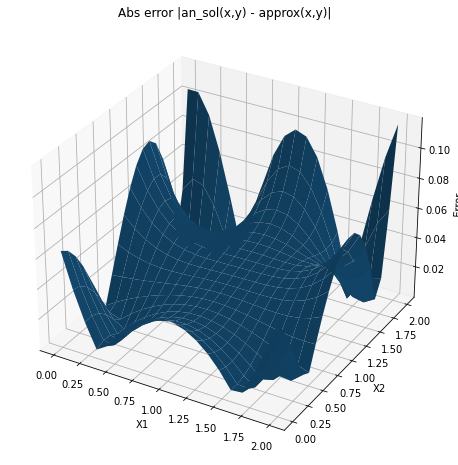

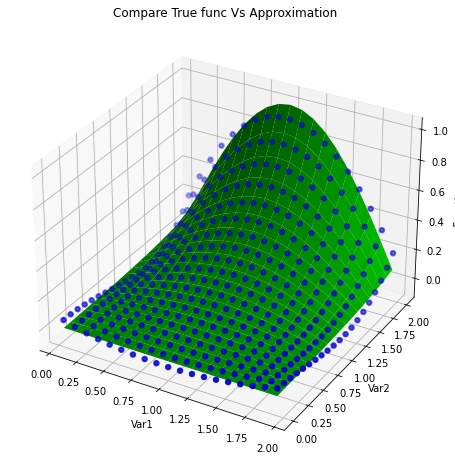

In [18]:
report.compare_appr_with_analytical()